Data Preprocessing, Regularization, Optimization, Hyper parameter, Batch Normalization 등 다양한 딥러닝 학습 기술들을 사용하여 MNIST 성능 높이기

- 성능 높이기: train/test accuracy 높이고 train/test loss 낮추기
- train/test data에 대한 accuracy 및 loss 시각화
- 학습데이터 수, learning rate, node 수, layer 수, epochs, dropout 및 규제화 비율 조절

## MNIST 분류

### Import Modules

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from collections import OrderedDict

### Load Data

In [ ]:
np.random.seed(42)

mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
num_classes = 10

11493376/11490434 [==============================] - 0s 0us/step


### Data Preprocessing

In [ ]:
np.random.seed(42)

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = 10

x_train = x_train[:20000]
x_test = x_test[:3000]

y_train = y_train[:20000]
y_test = y_test[:3000]

In [ ]:
x_train, x_test = x_train.reshape(-1, 28*28).astype(np.float32), x_test.reshape(-1, 28*28).astype(np.float32)

x_train = x_train / 255.
x_test = x_test / 255.

y_train = np.eye(num_classes)[y_train] # one hot vector
y_test = np.eye(num_classes)[y_test]

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(20000, 784)
(20000, 10)
(3000, 784)
(3000, 10)


### Util Functions

In [ ]:
def softmax(x):
  if x.ndim == 2:
    x = x.T
    x = x - np.max(x, axis=0)
    y = np.exp(x) / np.sum(np.exp(x), axis=0)
    return y.T

  x = x - np.max(x)
  return np.exp(x) / np.sum(np.exp(x))

def mean_squared_error(y, t):
  return 0.5 * np.sum((y-t)**2)

def cross_entropy_error(pred_y, true_y):
  if pred_y.ndim == 1:
    true_y = true_y.reshape(1, true_y.size)
    pred_y = pred_y.reshape(1, pred_y.size)

  if true_y.size == pred_y.size:
    true_y = true_y.argmax(axis=1)

  batch_size = pred_y.shape[0]
  return -np.sum(np.log(pred_y[np.arange(batch_size), true_y] + 1e-7)) / batch_size

### Util Classes

#### ReLU

In [ ]:
class ReLU():
  
  def __init__(self):
    self.mask = None

  def forward(self, input_data):
    self.mask = (input_data <= 0)
    self.out = input_data.copy()
    self.out[input_data < 0] = 0

    return self.out

  def backward(self, dout):
    dout[self.mask] = 0
    dx = dout

    return dx

#### Sigmoid

In [ ]:
class Sigmoid():

  def __init__(self):
    self.out = None

  def forward(self, x):
    out = 1 / (1 + np.exp(-x))
    self.out = out
    return out

  def backward(self, dout):
    dx = dout * (1.0 - self.out) * self.out
    return dx

#### Layer

In [ ]:
class Layer():

  def __init__(self, W, b):
    self.W = W
    self.b = b

    self.input_data = None
    self.input_data_shape = None
    
    self.dW = None
    self.db = None

  def forward(self, input_data):
    self.input_data_shape = input_data.shape

    input_data = input_data.reshape(input_data.shape[0], -1)
    self.input_data = input_data
    out = np.dot(self.input_data, self.W) + self.b

    return out

  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.input_data.T, dout)
    self.db = np.sum(dout, axis=0)

    dx = dx.reshape(*self.input_data_shape)
    return dx

#### Batch Normalization

In [ ]:
class BatchNormalization:

  def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
    self.gamma = gamma
    self.beta = beta
    self.momentum = momentum
    self.input_shape = None
    
    self.running_mean = running_mean
    self.running_var = running_var

    self.batch_size = None
    self.xc = None
    self.std = None
    self.dgamma = None
    self.dbeta = None

  def forward(self, input_data, is_train=True):
    self.input_shape = input_data.shape
    if input_data.ndim != 2:
      N, C, H, W = input_data.shape
      input_data = input_data.reshape(N, -1)

    out = self.__forward(input_data, is_train)

    return out.reshape(*self.input_shape)

  def __forward(self, input_data, is_train):
    if self.running_mean is None:
      N, D = input_data.shape
      self.running_mean = np.zeros(D)
      self.running_var = np.zeros(D)

    if is_train:
      mu = input_data.mean(axis=0)
      xc = input_data - mu
      var = np.mean(xc**2, axis=0)
      std = np.sqrt(var + 10e-7)
      xn = xc / std

      self.batch_size = input_data.shape[0]
      self.xc = xc
      self.xn = xn
      self.std = std
      self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
      self.running_var = self.momentum * self.running_var + (1-self.momentum) * var
    else:
      xc = input_data - self.running_mean
      xn = xc / ((np.sqrt(self.running_var + 10e-7)))

    out = self.gamma * xn + self.beta
    return out

  def backward(self, dout):
    if dout.ndim != 2:
      N, C, H, W = dout.shape
      dout = dout.reshape(N, -1)

    dx = self.__backward(dout)

    dx = dx.reshape(*self.input_shape)
    return dx

  def __backward(self, dout):
    dbeta = dout.sum(axis=0)
    dgamma = np.sum(self.xn * dout, axis=0)
    dxn = self.gamma * dout
    dxc = dxn / self.std
    dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
    dvar = 0.5 * dstd / self.std
    dxc += (2.0 / self.batch_size) * self.xc * dvar
    dmu = np.sum(dxc, axis=0)
    dx = dxc - dmu / self.batch_size

    self.dgamma = dgamma
    self.dbeta = dbeta

    return dx

#### Dropout


In [ ]:
class Dropout:

  def __init__(self, dropout_ratio=0.5):
    self.dropout_ratio = dropout_ratio
    self.mask = None

  def forward(self, input_data, is_train=True):
    if is_train:
      self.mask = np.random.rand(*input_data.shape) > self.dropout_ratio
      return input_data * self.mask
    else:
      return input_data * (1.0 - self.dropout_ratio)

  def backward(self, dout):
    return dout * self.mask

#### Softmax

In [ ]:
class Softmax:

  def __init__(self):
    self.loss = None
    self.y = None
    self.t = None

  def forward(self, input_data, t):
    self.t = t
    self.y = softmax(input_data)
    self.loss = cross_entropy_error(self.y, self.t)

    return self.loss

  def backward(self, dout=1):
    batch_size = self.t.shape[0]

    if self.t.size == self.y.size:
      dx = (self.y - self.t) / batch_size
    else:
      dx = self.y.copy()
      dx[np.arange(batch_size), self.t] -= 1
      dx = dx / batch_size

    return dx

#### Optimization - Adam

In [ ]:
class Adam:

  def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999):
    self.learning_rate = learning_rate
    self.beta1 = beta1
    self.beta2 = beta2
    self.iter = 0
    self.m = None
    self.v = None

  def update(self, params, grads):
    if self.m is None:
      self.m, self.v = {}, {}
      for key, val in params.items():
        self.m[key] = np.zeros_like(val)
        self.v[key] = np.zeros_like(val)

    self.iter += 1
    learning_rate_t = self.learning_rate * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

    for key in params.keys():
      self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
      self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])

      params[key] -= learning_rate_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

## Model

In [ ]:
class MyModel:

  def __init__(self, input_size, hidden_size_list, output_size,
               activation='relu', decay_lambda=0,
               use_dropout=False, dropout_ratio=0.5, use_batchnorm=False):
    self.input_size = input_size
    self.output_size = output_size
    self.hidden_size_list = hidden_size_list
    self.hidden_layer_num = len(hidden_size_list)
    self.use_dropout = use_dropout
    self.decay_lambda = decay_lambda
    self.use_batchnorm = use_batchnorm
    self.params = {}

    self.__init_weight(activation)

    activation_layer = {'sigmoid': Sigmoid, 'relu': ReLU}
    self.layers = OrderedDict()
    for idx in range(1, self.hidden_layer_num+1):
      self.layers['Layer' + str(idx)] = Layer(self.params['W' + str(idx)],
                                              self.params['b' + str(idx)])
      if self.use_batchnorm:
        self.params['gamma' + str(idx)] = np.ones(hidden_size_list[idx-1])
        self.params['beta' + str(idx)] = np.zeros(hidden_size_list[idx-1])
        self.layers['BatchNorm' + str(idx)] = BatchNormalization(self.params['gamma' + str(idx)], self.params['beta' + str(idx)])

      self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

      if self.use_dropout:
        self.layers['Dropout' + str(idx)] = Dropout(dropout_ratio)

    idx = self.hidden_layer_num + 1
    self.layers['Layer' + str(idx)] = Layer(self.params['W' + str(idx)], self.params['b' + str(idx)])
    self.last_layer = Softmax()

  def __init_weight(self, activation):
    all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]

    for idx in range(1, len(all_size_list)):
      scale = None
      if activation.lower() == 'relu':
        scale = np.sqrt(2.0 / all_size_list[idx-1])
      elif activation.lower() == 'sigmoid':
        scale = np.sqrt(1.0 / all_size_list[idx-1])

      self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
      self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

  def predict(self, x, is_train=False):
    for key, layer in self.layers.items():
      if "Dropout" in key or "BatchNorm" in key:
        x = layer.forward(x, is_train)
      else:
        x = layer.forward(x)

    return x

  def loss(self, x, t, is_train=False):
    y = self.predict(x, is_train)

    weight_decay = 0
    for idx in range(1, self.hidden_layer_num + 2):
      W = self.params['W' + str(idx)]
      weight_decay += 0.5 * self.decay_lambda * np.sum(W**2) # L2 규제

    return self.last_layer.forward(y, t) + weight_decay

  def accuracy(self, x, t):
    y = self.predict(x, is_train=False)
    y = np.argmax(y, axis=1)
    if t.ndim != 1:
      t = np.argmax(t, axis=1)

    accuracy = np.sum(y == t) / float(x.shape[0])
    return accuracy

  def gradient(self, x, t):
    self.loss(x, t, is_train=True)

    dout = 1
    dout = self.last_layer.backward(dout)

    layers = list(self.layers.values())
    layers.reverse()
    for layer in layers:
      dout = layer.backward(dout)

    grads = {}
    for idx in range(1, self.hidden_layer_num+2):
      grads['W' + str(idx)] = self.layers['Layer' + str(idx)].dW + self.decay_lambda * self.params['W' + str(idx)]
      grads['b' + str(idx)] = self.layers['Layer' + str(idx)].db

      if self.use_batchnorm and idx != self.hidden_layer_num+1:
        grads['gamma' + str(idx)] = self.layers['BatchNorm' + str(idx)].dgamma
        grads['beta' + str(idx)] = self.layers['BatchNorm' + str(idx)].dbeta

    return grads

### 모델 생성 및 학습
- 사용한 기법
  - 학습데이터 수 20,000

  - Hidden Layers : 4
    - [128, 64, 32, 16]
  - Optimizer: Adam
  - EPOCHS : 2000
  - 학습률 : 1e-3 (0.001)
  - 배치사이즈 : 256
  - 드롭아웃 : 0.3
  - 배치 정규화
  - 규제화 : 0.1

#### Hyper Parameters

In [ ]:
epochs = 2000
learning_rate = 1e-3
batch_size = 256
train_size = x_train.shape[0]
test_size = x_test.shape[0]
iter_per_epoch = max(train_size/batch_size, 1)

In [ ]:
decay_lambda = 0.1
model = MyModel(input_size=784, hidden_size_list=[128, 64, 32, 16], output_size=10,
                  decay_lambda=decay_lambda, use_dropout=True, dropout_ratio=0.3, use_batchnorm=True)

In [ ]:
optimizer = Adam(learning_rate=learning_rate)

In [ ]:
model_train_loss_list = []
model_test_loss_list = []
model_train_acc_list = []
model_test_acc_list = []

In [ ]:
for epoch in range(epochs):
  batch_mask = np.random.choice(train_size, batch_size)
  batch_mask_test = np.random.choice(test_size, batch_size)
  x_batch = x_train[batch_mask]
  y_batch = y_train[batch_mask]
  x_batch_test = x_test[batch_mask_test]
  y_batch_test = y_test[batch_mask_test]


  grads = model.gradient(x_batch, y_batch)
  optimizer.update(model.params, grads)

  train_loss = model.loss(x_batch, y_batch)
  test_loss = model.loss(x_batch_test, y_batch_test)
  model_train_loss_list.append(train_loss)
  model_test_loss_list.append(test_loss)

  train_acc = model.accuracy(x_train, y_train)
  test_acc = model.accuracy(x_test, y_test)
  model_train_acc_list.append(train_acc)
  model_test_acc_list.append(test_acc)

  if epoch % 100 == 0:
    print("[Model] Epoch: {} Train Loss: {:.4f} Test Loss: {:.4f} Train Accuracy: {:.4f} Test Accuracy: {:.4f}".format(epoch+1, train_loss, test_loss, train_acc, test_acc))

[Model] Epoch: 1 Train Loss: 39.0042 Test Loss: 39.4041 Train Accuracy: 0.0762 Test Accuracy: 0.0783
[Model] Epoch: 101 Train Loss: 7.1416 Test Loss: 7.2098 Train Accuracy: 0.7904 Test Accuracy: 0.7497
[Model] Epoch: 201 Train Loss: 3.5022 Test Loss: 3.5698 Train Accuracy: 0.8987 Test Accuracy: 0.8563
[Model] Epoch: 301 Train Loss: 2.2001 Test Loss: 2.2916 Train Accuracy: 0.9183 Test Accuracy: 0.8800
[Model] Epoch: 401 Train Loss: 1.6040 Test Loss: 1.7171 Train Accuracy: 0.9236 Test Accuracy: 0.8857
[Model] Epoch: 501 Train Loss: 1.3152 Test Loss: 1.4228 Train Accuracy: 0.9313 Test Accuracy: 0.8960
[Model] Epoch: 601 Train Loss: 1.1414 Test Loss: 1.2695 Train Accuracy: 0.9354 Test Accuracy: 0.9037
[Model] Epoch: 701 Train Loss: 1.0357 Test Loss: 1.1323 Train Accuracy: 0.9393 Test Accuracy: 0.9187
[Model] Epoch: 801 Train Loss: 0.9521 Test Loss: 1.0637 Train Accuracy: 0.9401 Test Accuracy: 0.9123
[Model] Epoch: 901 Train Loss: 0.9306 Test Loss: 1.0547 Train Accuracy: 0.9458 Test Accurac

#### 시각화

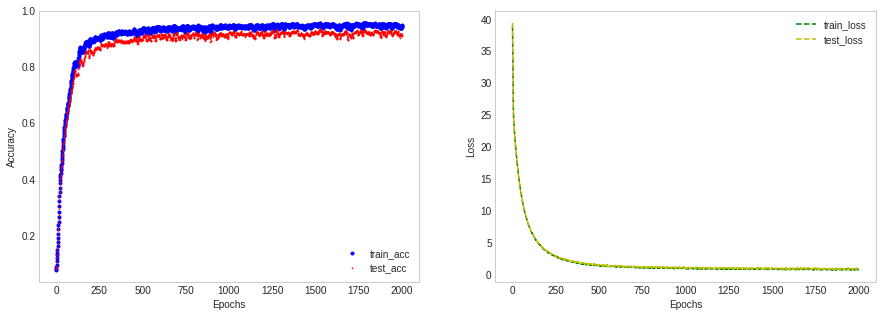

In [ ]:
x = np.arange(len(model_train_acc_list))

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(x, model_train_acc_list, 'bo', label='train_acc', markersize=3)
plt.plot(x, model_test_acc_list, 'rv', label='test_acc', markersize=1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(x, model_train_loss_list, 'g--', label='train_loss', markersize=3)
plt.plot(x, model_test_loss_list, 'y--', label='test_loss', markersize=1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()